<div align="center">

# **Quantum Generative Adversarial Network Implementation**

</div>

## Introduction
This notebook demonstrates the implementation and training of a **quantum generative adversarial network (qGAN)** using **Qiskit** and **PyTorch**. The goal is to learn a discrete approximation of a log-normal distribution by combining:

- **Quantum Generator**: A parameterized quantum circuit (PQC)
- **Classical Discriminator**: A neural network

The workflow includes:

1. **Data Preparation**: Sampling and discretizing a log-normal distribution  
2. **Quantum Circuit Design**: Custom ansatz for the generator  
3. **Model Training**: Adversarial training loop (GAN-style)  
4. **Visualization**: Loss curves and distribution comparison

This notebook provides a practical example of hybrid quantum-classical machine learning for generative modeling.

## 1. Setup & Imports

In [518]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, entropy, ks_2samp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad as torch_grad

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.primitives import Sampler

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set random seeds for reproducibility of results
np.random.seed(42)
torch.manual_seed(42)


## 2. Configuration

In [ ]:
class Config:
    '''
    Configuration class for the qGAN.
    Contains hyperparameters and settings for the quantum circuit, training, and data generation.
    Also includes device configuration for PyTorch.
    Attributes:
        NUM_QUBITS (int): Number of qubits in the quantum circuit.
        CIRCUIT_DEPTH (int): Depth of the ansatz circuit.
        QC_WEIGHT_INIT_RANGE (float): Range for initializing the circuit's weight parameters.
        LOGNORMAL_MU (float): Mean for the log-normal distribution used in data generation.
        LOGNORMAL_SIGMA (float): Standard deviation for the log-normal
            distribution used in data generation.
        DATA_RANGE_MIN (float): Minimum value for the data range.
        DATA_RANGE_MAX (float): Maximum value for the data range.
        BATCH_SIZE (int): Batch size for training.
        EPOCHS (int): Number of training epochs.
        GEN_LR (float): Learning rate for the generator.
        DISC_LR (float): Learning rate for the discriminator.
        DISC_INPUT_SIZE (int): Input size for the discriminator.
        DISC_HIDDEN_1 (int): Number of hidden units in the first layer of the discriminator.
        DISC_HIDDEN_2 (int): Number of hidden units in the second layer of the discriminator.
        DEVICE (torch.device): Device to run the computations on (CPU or GPU).
    Usage:
        config = Config()
        print(config.NUM_QUBITS)  # Access the number of qubits
        print(config.DEVICE)       # Check if CUDA is available
    '''
    NUM_QUBITS = 3
    CIRCUIT_DEPTH = 3 
    QC_WEIGHT_INIT_RANGE = 0.01 # Set after testing

    LOGNORMAL_MU = 1.0
    LOGNORMAL_SIGMA = 1.0
    DATA_RANGE_MIN = 0
    DATA_RANGE_MAX = 7

    BATCH_SIZE = 2000
    EPOCHS = 2000 
    GEN_LR = 2e-4   
    DISC_LR = 2e-4  

    DISC_INPUT_SIZE = 2**NUM_QUBITS
    DISC_HIDDEN_1 = 50
    DISC_HIDDEN_2 = 20

    # Use GPU if available, otherwise use CPU
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()
print(f"Using device: {config.DEVICE}")
num_classes = 2**config.NUM_QUBITS
print(f"Number of classes/bins: {num_classes}")

Using device: cpu
Number of classes/bins: 8


## 3. Real Data Generation

In [520]:
def generate_lognormal_distribution(cfg):
    '''
    Generates a log-normal distribution tensor based on the configuration parameters.
    Args:
        cfg (Config): Configuration object containing parameters for the log-normal distribution.
    Returns:
        torch.Tensor: A tensor representing the probability distribution of the log-normal samples.
    '''
    # Generate 20000 samples of a log-normal distribution
    samples_continuous = lognorm.rvs(s=cfg.LOGNORMAL_SIGMA, loc=0, scale=np.exp(cfg.LOGNORMAL_MU), size=20000)
    # Truncate the samples to [0,7]
    samples_truncated = samples_continuous[(samples_continuous >= cfg.DATA_RANGE_MIN) & (samples_continuous <= cfg.DATA_RANGE_MAX+1)]

    # Construct a histogram with 2^3 = 8 bins
    num_bins = 2**cfg.NUM_QUBITS
    bin_edges = np.linspace(cfg.DATA_RANGE_MIN, cfg.DATA_RANGE_MAX + 1, num_bins + 1)
    hist, _ = np.histogram(samples_truncated, bins=bin_edges, density=False)

    # Normalize the histogram to get a probability distribution
    if np.sum(hist) == 0: 
        prob_data = np.ones(num_bins) / num_bins
    else: 
        prob_data = hist / np.sum(hist)

    # Ensure no zero probabilities to avoid computational issues and normalize again
    prob_data = np.maximum(prob_data, 1e-9)
    prob_data = prob_data / np.sum(prob_data)

    return torch.tensor(prob_data, dtype=torch.float32, device=cfg.DEVICE)

# Generate the distribution tensor
lognormal_distribution_tensor = generate_lognormal_distribution(config)

## 4. Quantum Circuit

### 4.1 Circuit creation

In [521]:
def initialize_state_custom(qubit_num):
    '''
    Initializes a quantum circuit with a uniform superposition state.
    Args:
        qubit_num (int): Number of qubits in the quantum circuit.
    Returns:
        QuantumCircuit: A quantum circuit with all qubits in a uniform superposition state.
    '''
    qc = QuantumCircuit(qubit_num)
    qc.h(qc.qubits)
    return qc

def create_variational_form(qubit_num, num_repetitions, param_prefix="θ"):
    '''
    Creates a custom variational form for a quantum circuit.
    Args:
        qubit_num (int): Number of qubits in the quantum circuit.
        num_repetitions (int): Number of repetitions for the entanglement and rotation layers.
        param_prefix (str): Prefix for the parameter names.
    Returns:
        tuple: A tuple containing the quantum circuit and a flat list of parameters.
    '''
    qc = initialize_state_custom(qubit_num)
    qc.barrier(label="Initial H")

    # Create parameters for the variational form
    theta_params = [[Parameter(f"{param_prefix}_{q}_{layer_idx}") for layer_idx in range(num_repetitions + 1)] for q in range(qubit_num)]
    
    for q_idx in range(qubit_num): 
        qc.ry(theta_params[q_idx][0], q_idx)
    
    qc.barrier(label="Initial Ry")
    
    for rep_idx in range(num_repetitions):
        # Add entanglement layer with CZ gates
        for q_idx in range(qubit_num - 1): 
            qc.cz(q_idx, q_idx + 1)
            
        # Add a CZ gate between the last qubit and the first qubit
        if qubit_num > qubit_num - 1: 
            qc.cz(qubit_num - 1, 0)

        qc.barrier(label="CZ Layer")

        # Add rotation layer with Ry gates
        for q_idx in range(qubit_num): 
            qc.ry(theta_params[q_idx][rep_idx+1], q_idx)

        qc.barrier(label="Ry Layer")

    flat_parameter_list = [p for sublist in theta_params for p in sublist]
    return qc, flat_parameter_list

### 4.2 Circuit Visualization

Number of parameters in the circuit: 12


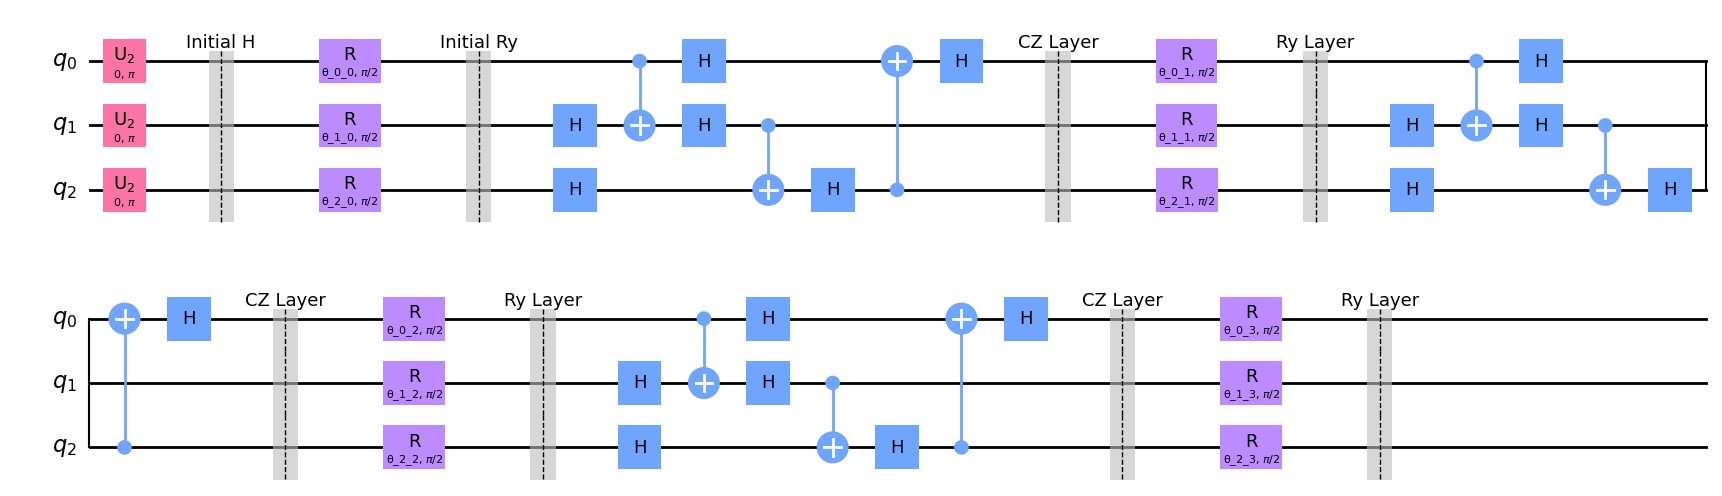

In [522]:
my_qc, my_params = create_variational_form(
    config.NUM_QUBITS, config.CIRCUIT_DEPTH, param_prefix="θ"
)
print(f"Number of parameters in the circuit: {len(my_params)}")
my_qc.decompose().draw(output="mpl", style="clifford")

## 5. Quantum Generator

In [ ]:
def create_quantum_generator(cfg):
    '''
    Creates a quantum generator using a custom variational form.
    Args:
        cfg (Config): Configuration object containing parameters for the quantum circuit.
    Returns:
        tuple: A tuple containing the TorchConnector for the quantum generator and the quantum circuit.
    '''
    qc, params_list = create_variational_form(cfg.NUM_QUBITS, cfg.CIRCUIT_DEPTH)
    
    # Initialize the parameters for the custom circuit
    initial_custom_params_values = np.random.uniform(-cfg.QC_WEIGHT_INIT_RANGE, cfg.QC_WEIGHT_INIT_RANGE, len(params_list))

    # Create a sampler and a SamplerQNN for the custom quantum circuit
    sampler = Sampler()
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[], 
        weight_params=params_list, 
        sparse=False
    )

    # Initialize the weights tensor with the custom parameters
    initial_weights_tensor = torch.tensor(initial_custom_params_values, dtype=torch.float32)
    return TorchConnector(qnn, initial_weights=initial_weights_tensor)

quantum_generator = create_quantum_generator(config)


/tmp/ipykernel_1572681/3086247299.py:15: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/tmp/ipykernel_1572681/3086247299.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(
/home/diman/Desktop/TUC/8/Εισαγωγή στους Κβαντικούς Υπολογιστές/qproj_venv/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:374: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), 

## 5. Classical Discriminator

In [524]:
class ClassicalDiscriminator(nn.Module):
    '''
    Classical Discriminator for the qGAN.
    This class defines a simple feedforward neural network to discriminate between real and generated data.
    Attributes:
        input_size (int): Size of the input layer, equal to the number of classes.
        model (nn.Sequential): Sequential model containing linear layers and activation functions.
    '''
    def __init__(self, cfg):
        super().__init__()
        self.input_size = cfg.DISC_INPUT_SIZE
        self.model = nn.Sequential(
            nn.Linear(self.input_size, cfg.DISC_HIDDEN_1),
            nn.LeakyReLU(0.2),
            nn.Linear(cfg.DISC_HIDDEN_1, cfg.DISC_HIDDEN_2), 
            nn.LeakyReLU(0.2),
            nn.Linear(cfg.DISC_HIDDEN_2, 1),
            nn.Sigmoid()
        )
    def forward(self, x): 
        return self.model(x)

classical_discriminator = ClassicalDiscriminator(config).to(config.DEVICE)

## 6. Utility and Helper Functions

In [ ]:
all_possible_outcomes_indices = torch.arange(num_classes, device=config.DEVICE)
all_possible_outcomes_one_hot = nn.functional.one_hot(all_possible_outcomes_indices, num_classes=num_classes).float()

def adversarial_loss(discriminator_output_on_all_samples, target_label_value, weights_distribution):
    '''
    Calculates the adversarial loss in a style similar to Qiskit.
    Args:
        discriminator_output_on_all_samples (torch.Tensor): Output of the discriminator for all samples.
        target_label_value (float): Target label value (0 or 1) for the loss calculation.
        weights_distribution (torch.Tensor): Weights distribution for the samples.
    Returns:
        torch.Tensor: The calculated adversarial loss.
    '''
    epsilon = 1e-9
    d_output_flat = discriminator_output_on_all_samples.squeeze()
    weights_flat = weights_distribution.squeeze()

    if target_label_value > 0.5:
        term = torch.log(d_output_flat + epsilon)
    else:
        term = torch.log(1.0 - d_output_flat + epsilon)

    weighted_bce_terms = weights_flat * term
    total_loss = -torch.sum(weighted_bce_terms)

    return total_loss


def create_one_hot_batch(probability_vector_np, batch_size, num_classes_local, device_local):
    '''
    Creates a one-hot encoded batch of samples based on the provided probability vector.
    Args:
        probability_vector_np (np.ndarray): Probability vector for sampling.
        batch_size (int): Size of the batch to create.
        num_classes_local (int): Number of classes for one-hot encoding.
        device_local (torch.device): Device to create the one-hot encoded tensor on.
    Returns:
        torch.Tensor: A one-hot encoded tensor of shape (batch_size, num_classes_local).
    '''
    probability_vector_np = np.maximum(probability_vector_np, 1e-9)
    probability_vector_np = probability_vector_np / np.sum(probability_vector_np)

    # Sample indices based on the probability vector
    sampled_indices = np.random.choice(num_classes_local, size=batch_size, p=probability_vector_np)

    # Create a one-hot encoded tensor 
    one_hot_batch = torch.zeros(batch_size, num_classes_local, device=device_local) 
    one_hot_batch[torch.arange(batch_size), sampled_indices] = 1.0 
    
    return one_hot_batch


def calculate_metrics_on_distributions(generated_probs_np, real_probs_np):
    '''
    Calculates the KL divergence and KS statistic between two probability distributions.
    Args:
        generated_probs_np (np.ndarray): Probability distribution of the generated samples.
        target_probs_np (np.ndarray): Probability distribution of the target samples.
    Returns:
        tuple: A tuple containing the KL divergence and KS statistic.
    '''
    epsilon = 1e-10
    gen_p = np.maximum(generated_probs_np, epsilon)
    gen_p /= np.sum(gen_p)
    real_p = np.maximum(real_probs_np, epsilon)
    real_p /= np.sum(real_p)


    num_samples_for_ks = 20000
    gen_samples = np.random.choice(len(gen_p), size=num_samples_for_ks, p=gen_p)
    target_samples = np.random.choice(len(real_p), size=num_samples_for_ks, p=real_p)

    kl_divergence = entropy(pk=real_p, qk=gen_p)
    ks_statistic, _ = ks_2samp(gen_samples, target_samples)
    
    return kl_divergence, ks_statistic

## 7. Training Loop

### 7.1 Initialize networks in the available device (GPU / CPU)

In [526]:
generator = quantum_generator.to(config.DEVICE)
discriminator = classical_discriminator.to(config.DEVICE)

### 7.2 Setup Optimizers

In [527]:
optimizer_G = optim.Adam(generator.parameters(), lr=config.GEN_LR, amsgrad=True)
optimizer_D = optim.Adam(discriminator.parameters(), lr=config.DISC_LR, amsgrad=True)

### 7.3 Training Function

In [ ]:
# Variables usefull for logging and tracking the training process
history = {'G_loss': [], 'D_loss': [], 'KL_div': [], 'KS_stat': []}
criterion = nn.BCELoss()

# Function to train the qGAN model
def train(config, generator, discriminator, lognormal_distribution_tensor, history, criterion, optimizer_G, optimizer_D):
    '''
    Trains the qGAN model using the provided generator and discriminator.
    Args:
        config (Config): Configuration object containing hyperparameters and settings.
        generator (TorchConnector): The quantum generator model.
        discriminator (nn.Module): The classical discriminator model.
        lognormal_distribution_tensor (torch.Tensor): Tensor representing the target log-normal distribution.
        history (dict): Dictionary to store training history for logging and analysis.
        criterion (nn.Module): Loss function for training the discriminator.
        optimizer_G (torch.optim.Optimizer): Optimizer for the generator.
        optimizer_D (torch.optim.Optimizer): Optimizer for the discriminator.
    Returns:
        None
    This function performs the training loop, updating the generator and discriminator models.
    '''
    # Training loop
    for epoch in range(config.EPOCHS):

        # ====== STEP 1: Discriminator training with REAL data ======
        optimizer_D.zero_grad()
        real_data_samples_batch = create_one_hot_batch(lognormal_distribution_tensor.cpu().numpy(),
                                                        config.BATCH_SIZE, num_classes, config.DEVICE)
        labels_real_smoothed = torch.full((config.BATCH_SIZE, 1), 1.0,device=config.DEVICE)
        pred_real = discriminator(real_data_samples_batch)
        loss_D_real = criterion(pred_real, labels_real_smoothed)
        
        # ====== STEP 2: Discriminator training with FAKE data ======
        with torch.no_grad():
            current_gen_probs_tensor_for_D = generator(torch.tensor([]).to(config.DEVICE)).squeeze()

        # Generate fake data samples using the generator
        fake_data_samples_batch = create_one_hot_batch(current_gen_probs_tensor_for_D.cpu().numpy(),
                                                        config.BATCH_SIZE, num_classes, config.DEVICE)
        labels_fake_smoothed_for_D = torch.full((config.BATCH_SIZE, 1), 0.0,device=config.DEVICE)
        pred_fake_detached = discriminator(fake_data_samples_batch)

        # No weights needed for the discriminator loss
        loss_D_fake = criterion(pred_fake_detached, labels_fake_smoothed_for_D)
            
        # Combine average value of loss and perform backpropagation
        loss_D = (loss_D_real + loss_D_fake)/2
        loss_D.backward()
        optimizer_D.step()

        # ====== STEP 3: Generator training based on Discriminator's output ======
        optimizer_G.zero_grad()
        gen_probs_for_G_loss = generator(torch.tensor([]).to(config.DEVICE)).squeeze()
        d_eval_on_all_outcomes = discriminator(all_possible_outcomes_one_hot)
        loss_G = adversarial_loss(
            discriminator_output_on_all_samples=d_eval_on_all_outcomes,
            target_label_value=1, 
            weights_distribution=gen_probs_for_G_loss
        )
        loss_G.backward()
        optimizer_G.step()
        
        # ====== STEP 4: Calculate Relative Entropy, Kolmogorv-Smirnov statistic and store process ======
        with torch.no_grad():
            current_gen_probs_tensor = generator(torch.tensor([]).to(config.DEVICE)).squeeze()
            current_gen_probs_np = current_gen_probs_tensor.cpu().numpy()

        # Calculate Relative Entropy and KS statistic
        kl_div, ks_stat = calculate_metrics_on_distributions(current_gen_probs_np, lognormal_distribution_tensor.cpu().numpy())

        # Store the losses and metrics in the history dictionary
        history['G_loss'].append(loss_G.item()) 
        history['D_loss'].append(loss_D.item())
        history['KL_div'].append(kl_div) 
        history['KS_stat'].append(ks_stat)

        # Print the progress every 100 epochs and in the last one
        if epoch % 100 == 0 or epoch == config.EPOCHS - 1:
            print(f"Epoch [{epoch}/{config.EPOCHS}] | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f} | Relative Entropy: {kl_div:.4f} | Kolmogorv–Smirnov statistic: {ks_stat:.4f}")

### 7.4 Training Execution

In [529]:
print("Starting qGAN training...")
train(config, generator, discriminator, lognormal_distribution_tensor, history, criterion, optimizer_G, optimizer_D)
print("Training finished.")

Starting qGAN training...
Epoch [0/2000] | Loss D: 0.6946 | Loss G: 0.7427 | Relative Entropy: 0.1732 | Kolmogorv–Smirnov statistic: 0.2531
Epoch [100/2000] | Loss D: 0.6855 | Loss G: 0.7171 | Relative Entropy: 0.1344 | Kolmogorv–Smirnov statistic: 0.2365
Epoch [200/2000] | Loss D: 0.6772 | Loss G: 0.7075 | Relative Entropy: 0.0988 | Kolmogorv–Smirnov statistic: 0.2012
Epoch [300/2000] | Loss D: 0.6745 | Loss G: 0.7257 | Relative Entropy: 0.0689 | Kolmogorv–Smirnov statistic: 0.1683
Epoch [400/2000] | Loss D: 0.6760 | Loss G: 0.7367 | Relative Entropy: 0.0480 | Kolmogorv–Smirnov statistic: 0.1280
Epoch [500/2000] | Loss D: 0.6856 | Loss G: 0.7253 | Relative Entropy: 0.0360 | Kolmogorv–Smirnov statistic: 0.1047
Epoch [600/2000] | Loss D: 0.6873 | Loss G: 0.7188 | Relative Entropy: 0.0240 | Kolmogorv–Smirnov statistic: 0.0882
Epoch [700/2000] | Loss D: 0.6877 | Loss G: 0.7132 | Relative Entropy: 0.0189 | Kolmogorv–Smirnov statistic: 0.0719
Epoch [800/2000] | Loss D: 0.6890 | Loss G: 0.70

## 8. Results and Visualization

### 8.1 Training Visualization

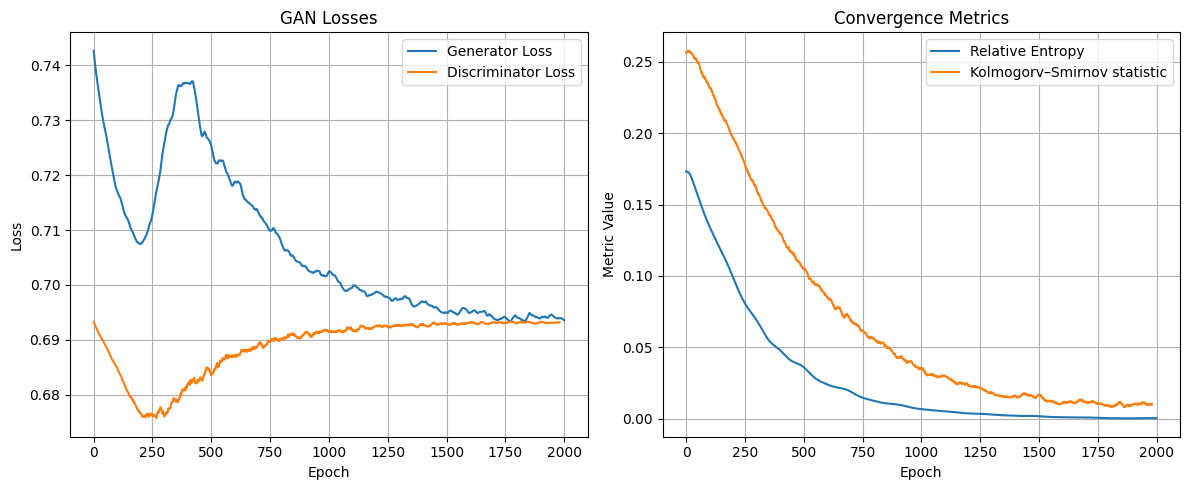

In [ ]:
# Function to plot the training history in a clear way
def moving_average(data, window_size):
    if len(data) < window_size:
        return data # Not enough data to average
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window = 20 # Adjust as needed

plt.figure(figsize=(12, 5)) 

plt.subplot(1, 2, 1)
plt.plot(history['G_loss'], label='Generator Loss')
plt.plot(moving_average(history['D_loss'], window), label='Discriminator Loss')
plt.title('GAN Losses')
plt.xlabel(f'Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['KL_div'], label='Relative Entropy')
plt.plot(moving_average(history['KS_stat'], window), label='Kolmogorv–Smirnov statistic')
plt.title('Convergence Metrics')
plt.xlabel(f'Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 8.2 Results

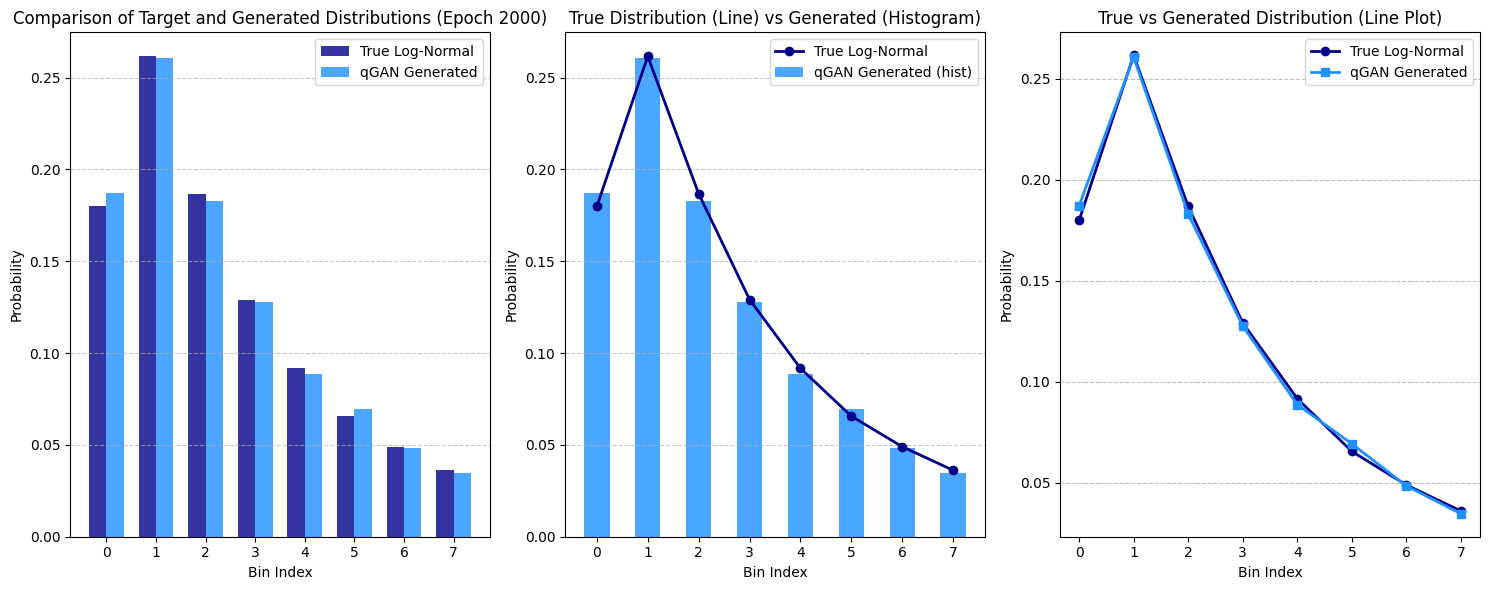


Final Metrics after 2000 epochs:
  Relative Entropy: 0.0004
  Kolmogorv–Smirnov statistic: 0.0081


In [ ]:
with torch.no_grad():
    final_generated_probs_tensor = generator(torch.tensor([]).to(config.DEVICE)).squeeze()
    final_generated_probs_np = final_generated_probs_tensor.cpu().numpy()
    final_generated_probs_np = np.maximum(final_generated_probs_np, 0); final_generated_probs_np /= np.sum(final_generated_probs_np)

# Bar plot comparison 
plt.figure(figsize=(15, 6))

# 1. Both as bar plots
plt.subplot(1, 3, 1)
bar_width = 0.35
index = np.arange(num_classes)
plt.bar(index - bar_width/2, lognormal_distribution_tensor.cpu().numpy(), bar_width, label='True Log-Normal', color='darkblue', alpha=0.8)
plt.bar(index + bar_width/2, final_generated_probs_np, bar_width, label='qGAN Generated', color='dodgerblue', alpha=0.8)
plt.xlabel('Bin Index')
plt.ylabel('Probability')
plt.title(f'Comparison of Target and Generated Distributions (Epoch {config.EPOCHS})')
plt.xticks(index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. True as line plot, generated as histogram
plt.subplot(1, 3, 2)

plt.plot(index, lognormal_distribution_tensor.cpu().numpy(), marker='o', label='True Log-Normal', color="darkblue", linewidth=2)  # dark orange
plt.bar(index, final_generated_probs_np, width=0.5, alpha=0.8, label='qGAN Generated (hist)', color="dodgerblue")
plt.xlabel('Bin Index')
plt.ylabel('Probability')
plt.title('True Distribution (Line) vs Generated (Histogram)')
plt.xticks(index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 3. Both as line plots
plt.subplot(1, 3, 3)
plt.plot(index, lognormal_distribution_tensor.cpu().numpy(), marker='o', label='True Log-Normal', color='darkblue', linewidth=2)
plt.plot(index, final_generated_probs_np, marker='s', label='qGAN Generated', color='dodgerblue', linewidth=2)
plt.xlabel('Bin Index')
plt.ylabel('Probability')
plt.title('True vs Generated Distribution (Line Plot)')
plt.xticks(index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

final_kl, final_ks = calculate_metrics_on_distributions(final_generated_probs_np, lognormal_distribution_tensor.cpu().numpy())
print(f"\nFinal Metrics after {config.EPOCHS} epochs:")
print(f"  Relative Entropy: {final_kl:.4f}")
print(f"  Kolmogorv–Smirnov statistic: {final_ks:.4f}")